<a href="https://colab.research.google.com/github/Vinayak-Sharma12/LangGraph/blob/main/5_Integrate_MultipleTools_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install langgraph wikipedia langchain langchain_community langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 9.8 MB/s eta 0:00:00


## **CREATE STATE**

In [4]:
from typing_extensions import TypedDict
from langgraph.graph import add_messages
from typing import Annotated

In [5]:
class State(TypedDict):
  messages:Annotated[list,add_messages]

## **TOOL**

In [20]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain.tools import WikipediaQueryRun
wiki=WikipediaAPIWrapper(top_k_results=3)
wiki=WikipediaQueryRun(api_wrapper=wiki)

In [21]:
wiki.run("Hello")

/usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


'Page: Hello\nSummary: Hello is a salutation or greeting in the English language. It is first attested in writing from 1826.\n\nPage: Hello Kitty\nSummary: Hello Kitty (Japanese: ハロー・キティ, Hepburn: Harō Kiti), also known by her real name Kitty White (キティ・ホワイト, Kiti Howaito), is a fictional character created by Yuko Shimizu, currently designed by Yuko Yamaguchi, and owned by the Japanese company Sanrio. Sanrio depicts Hello Kitty as a British anthropomorphized white cat with a red bow and no visible mouth. According to her backstory, she lives in a London suburb with her family, and is close to her twin sister Mimmy, who is depicted with a yellow bow.\nHello Kitty was created in 1974 and the first item, a vinyl coin purse, was introduced in 1975. Originally, Hello Kitty was only marketed towards pre-teenage girls, but beginning in the 1990s, the brand found commercial success among teenage and adult consumers as well. Hello Kitty\'s popularity also grew with the emergence of kawaii (cute

In [6]:
def add(a:int,b:int)->int:
  """Add two number"""
  return a+b

In [7]:
def sub(a:int,b:int)->int:
  "Subtract two number"
  return a-b


In [23]:
tools=[wiki,add,sub]

## **BINDING TOOL WITH LLM**

In [41]:
from langchain_groq import ChatGroq
llm=ChatGroq(model='llama-3.1-8b-instant',api_key='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')

In [42]:
llm.invoke("Hello")

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 36, 'total_tokens': 44, 'completion_time': 0.011618862, 'prompt_time': 0.003291013, 'queue_time': 0.216093433, 'total_time': 0.014909875}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'stop', 'logprobs': None}, id='run--c5bec18b-5840-42a4-bc19-3d93b9a51ce3-0', usage_metadata={'input_tokens': 36, 'output_tokens': 8, 'total_tokens': 44})

In [43]:
llm_with_tools=llm.bind_tools(tools)

## **CREATE NODE**

In [44]:
def llm_tools(state:State):
  return {"messages":llm_with_tools.invoke(state['messages'])}

### **GRAPH**

In [45]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode,tools_condition
builder=StateGraph(State)

#ADD NODES
builder.add_node("llm_tools",llm_tools)
builder.add_node("tools",ToolNode(tools))

#ADD EDGES
builder.add_edge(START,"llm_tools")
builder.add_conditional_edges("llm_tools",tools_condition) #if tool call it route to tool else to END
builder.add_edge("tools",END)

#COMPILE
graph=builder.compile()

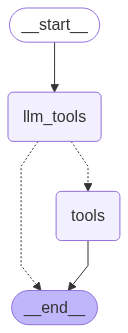

In [46]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [49]:
graph.invoke({"messages":"Tell me something about Vinayak Sharma"})

{'messages': [HumanMessage(content='Tell me something about Vinayak Sharma', additional_kwargs={}, response_metadata={}, id='8890034b-f925-40f7-be34-c9aed92ac35e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dfqp', 'function': {'arguments': '{"query": "Vinayak Sharma"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 393, 'total_tokens': 410, 'completion_time': 0.022666667, 'prompt_time': 0.012163416, 'queue_time': 0.216468994, 'total_time': 0.034830083}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f7bd09b454', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--310a43f0-0141-40c1-815a-ef8382b5bcb6-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Vinayak Sharma'}, 'id': 'call_dfqp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 393, 'output_tokens': 17, 'total_tokens': 410}),
  ToolMessage(content='Page: Taaruk Raina\nSummary: Taaruk Raina i